In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'ENPM703/Assignment/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/ENPM703/Assignment/assignment1/cs231n/datasets
/content/drive/My Drive/ENPM703/Assignment/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.370555
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$

In the CIFAR-10 dataset we have 10 classes. The weights are initialized randomly and the softmax changes vector of raw scores into probabilities, which means the probability of correctly classifying the true lable by guessing randomly is $0.1$. We know that the softmax loss is the negative log of the probabilitu of the class, therefore it is $-log(0.1)$.


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.842204 analytic: 0.842204, relative error: 1.068402e-08
numerical: -1.960231 analytic: -1.960231, relative error: 2.178663e-10
numerical: 0.065203 analytic: 0.065203, relative error: 7.603943e-07
numerical: 1.039746 analytic: 1.039746, relative error: 1.152572e-07
numerical: 1.393444 analytic: 1.393444, relative error: 1.385434e-08
numerical: -1.065056 analytic: -1.065056, relative error: 4.878247e-08
numerical: 1.011962 analytic: 1.011962, relative error: 1.807875e-08
numerical: -2.269716 analytic: -2.269716, relative error: 6.017054e-09
numerical: 1.444255 analytic: 1.444255, relative error: 1.317200e-08
numerical: -0.143295 analytic: -0.143295, relative error: 2.395539e-07
numerical: 2.479239 analytic: 2.479238, relative error: 3.708769e-08
numerical: -2.788008 analytic: -2.788008, relative error: 1.758190e-08
numerical: 0.740857 analytic: 0.740857, relative error: 3.777680e-08
numerical: -0.667514 analytic: -0.667515, relative error: 5.293720e-08
numerical: 1.813770 an

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.370555e+00 computed in 0.249766s
vectorized loss: 2.370555e+00 computed in 0.075661s
Loss difference: 0.000000
Gradient difference: 0.000000


In [10]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 5e-7]
regularization_strengths = [2.5e4, 2.5e5, 2.5e6, 2.5e7, 2.5e8, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid_search = [ (lr, rg) for lr in learning_rates for rg in regularization_strengths]

for lr, rg in grid_search:
    # Creating a new Softmax instance
    softmax_model = Softmax()
    # Training the model with current parameters
    softmax_model.train(X_train, y_train, learning_rate=lr, reg=rg, num_iters=1000)
    # Predicting values for training set
    y_train_pred = softmax_model.predict(X_train)
    # Calculating training accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predicting values for validation set
    y_val_pred = softmax_model.predict(X_val)
    # Calculating validation accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Saving the results with best validation accuracy
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_softmax = softmax_model


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

/content/drive/My Drive/ENPM703/Assignment/assignment1/cs231n/classifiers/softmax.py:89: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(softmax_matrix[np.arange(num_train), y]) )
/content/drive/My Drive/ENPM703/Assignment/assignment1/cs231n/classifiers/softmax.py:100: RuntimeWarning: overflow encountered in scalar multiply
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/ENPM703/Assignment/assignment1/cs231n/classifiers/softmax.py:100: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/content/drive/My Drive/ENPM703/Assignment/assignment1/cs231n/classifiers/softmax.py:101: RuntimeWarning: overflow encountered in multiply
  dW += reg * 2 * W
/content/drive/My Drive/ENPM703/Assignment/assignment1/cs231n/classifiers/softmax.py:84: RuntimeWarning: overflow 

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.326898 val accuracy: 0.331000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.305408 val accuracy: 0.324000
lr 1.000000e-07 reg 2.500000e+05 train accuracy: 0.247184 val accuracy: 0.267000
lr 1.000000e-07 reg 2.500000e+06 train accuracy: 0.227286 val accuracy: 0.238000
lr 1.000000e-07 reg 2.500000e+07 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-07 reg 2.500000e+08 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.317102 val accuracy: 0.344000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.299531 val accuracy: 0.326000
lr 5.000000e-07 reg 2.500000e+05 train accuracy: 0.257327 val accuracy: 0.278000
lr 5.000000e-07 reg 2.500000e+06 train accuracy: 0.109388 val accuracy: 0.109000
lr 5.000000e-07 reg 2.500000e+07 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-07 reg 2.500000e+08 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-06 reg 2.500000

In [11]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.339000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ *True*


$\color{blue}{\textit Your Explanation:}$

It is possible to add a new datapoint to a training set that leaves the SVM loss unchanged (if the datapoint is correctly classified with a margin greater than the threshold), but this is not the case with the Softmax classifier loss, where every new datapoint will contribute some loss, even if it is correctly classified with high confidence.

##Explanation
### 1. **SVM Loss**
The SVM loss for a single datapoint $(x_i, y_i)$ is given by:

$$
L_{\text{SVM}} = \sum_{i \neq c} \max(0, \hat{y_i} - \hat{y_c} + \Delta)
$$

where $ x_i $ is the input, $ y_i $ is the true label for class $ i $, and $ \Delta $ is a margin.

- In SVM, only the **support vectors** (the points near the decision boundary) contribute to the overall loss. If a new datapoint is **correctly classified** with a margin larger than $ \Delta $, its loss contribution is zero.
  
- Therefore, adding a new datapoint that is far from the decision boundary (i.e., correctly classified with a large margin) does not change the loss.

Thus, it is possible to add a new datapoint to the SVM training set that **does not change the overall loss**.

### 2. **Softmax Classifier Loss**
The Softmax classifier uses the **cross-entropy loss**. For a single datapoint $ (x_i, y_i) $, the loss is given by:

$$
L_{\text{Softmax}} = -\log \frac{e^{\hat{y_c}}}{\sum_i e^\hat{y_i}}
$$

- Unlike SVM, the Softmax loss is **non-zero for every datapoint**, regardless of how far the datapoint is from the decision boundary. Even if a datapoint is correctly classified with high confidence, it still contributes some loss, although it may be very small.
  
- Thus, adding any new datapoint will always have some effect on the overall Softmax loss because the logarithmic term means that even points that are correctly classified with high confidence contribute a small amount to the loss.

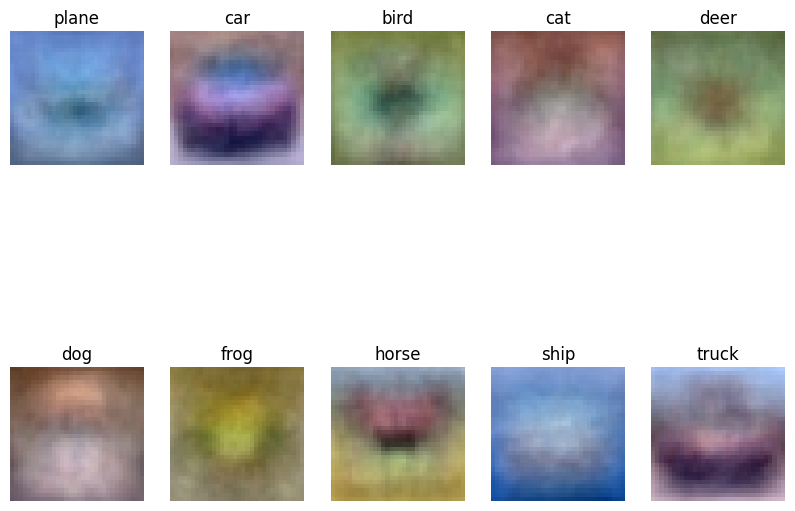

In [12]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])